## Загрузка данных и библиотек

In [1]:
import pymorphy2
import textdistance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch import tensor
from torch.optim import Adam

from tqdm import tqdm
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.cuda.is_available()

False

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [4]:
df = pd.read_csv('train.csv')
df_public = pd.read_csv('test.csv')

## Feature Engineering и обучение модели

#### Группы фич 1-4

In [5]:
%%time

morph = pymorphy2.MorphAnalyzer()

chars = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц',
         'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']

char_dict = {char:chars.index(char) for char in chars}
feature_list = ['pos', 'case', 'gender', 'tense', 'number','person', 'transitivity', 'starts_with', 'ends_with', 'distance']


def feature_engineering(word, lemma):
    # 1. морфемы слова - часть речи, падеж, род, время, число, лицо, переходность
    p = morph.parse(word)[0] 
    
    # 2. one-hot кодирование каждой буквы в слове
    char_string = np.zeros((len(chars))) 
    
    for character in word:
        char_string[char_dict[character]] += 1 
    
    # 3. нормализированное расстояние Левенштейна между леммой и словом
    distance = textdistance.hamming.normalized_similarity(word, lemma) 
    
    # 4. первая и последняя буквы слова
    first_char = word[0] 
    last_char =  word[-1]
        
    return [p.tag.POS, p.tag.case, p.tag.gender, p.tag.tense, p.tag.number, p.tag.person, p.tag.transitivity, first_char, 
            last_char, distance] + list(char_string)


df[feature_list+chars] = df.apply(lambda row : feature_engineering(row['word'], row['lemma']), axis = 1).tolist()

feature_final_list = feature_list[:]
feature_final_list.remove('distance')

Wall time: 9.78 s


#### Группа фич 5

In [6]:
%%time

# 5. позиция гласной в каждом слове (какой это по счёту слог)
vowels = "аеёиоуюяыэ"
syl_numbers = ['syl_1', 'syl_2', 'syl_3', 'syl_4', 'syl_5', 'syl_6']
syl_list=[]

for i in vowels:
    for j in syl_numbers:
        syl_list.append(i+'_'+j)
        

def syl_listing(word, num_syllables):
    syl_dict = {x: 0 for x in syl_list}
    syl_count=0
    for i in range(len(word)):
        if word[i] in vowels:
            syl_count+=1
            syl_dict[f'{word[i]}_syl_{syl_count}'] = 1
    return list(syl_dict.values())

df[syl_list] = df.apply(lambda row : syl_listing(row['word'],row['num_syllables']), axis = 1).tolist()
df_public[syl_list] = df_public.apply(lambda row : syl_listing(row['word'],row['num_syllables']), axis = 1).tolist()

Wall time: 3.14 s


#### 6-ая фича (количество слогов) и создание таблицы признаков

In [7]:
X = pd.concat([pd.get_dummies(df[(feature_final_list+['num_syllables'])]), df[chars], df[syl_list], df['distance']], axis=1).astype('float32')
y = df['stress']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Обучение нейросети

В этом разделе сохранена попытка создать feature extractor для букв и слогов с помощью 1-D сверток и классификатор на основе LSTM.

In [8]:
max_tokens = 20
batch_size = 512

def tokenize_words(word):
    return [ord(char) for char in word]+([0]*(max_tokens-len(word)))

df['tokenized_words'] = df['word'].apply(tokenize_words)
df_public['tokenized_words'] = df_public['word'].apply(tokenize_words)

dataset = torch.utils.data.TensorDataset(tensor(df['tokenized_words'], dtype=torch.int64), tensor(df['stress']-1, dtype=torch.int64))
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
final_loader = DataLoader(torch.tensor(df_public['tokenized_words'], dtype=torch.int32), batch_size=batch_size)

In [9]:
class StressClassifier(nn.Module):
    out_channels = 2
    hidden_layers = 100
    
    def __init__(self):
        super(StressClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, self.out_channels, 1)
        self.conv2 = nn.Conv1d(self.out_channels, 1, kernel_size=3)
        self.lstm = nn.LSTM(18, self.hidden_layers, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(self.hidden_layers*2, 64)
        self.fc2 = nn.Linear(64, 6)

    def forward(self, X_batch):
        x = X_batch.reshape(len(X_batch), 1, max_tokens)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x, _ = self.lstm(x)
        x = x.view(len(X_batch), self.hidden_layers*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X.float())
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X.float())
            
            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [11]:
epochs = 20
learning_rate = 1e-5

loss_fn = nn.CrossEntropyLoss()
conv_classifier = StressClassifier()
optimizer = Adam(conv_classifier.parameters(), lr=learning_rate)

TrainModel(conv_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 100/100 [00:01<00:00, 54.46it/s]


Train Loss : 1.776
Valid Loss : 1.757
Valid Acc  : 0.292


100%|██████████| 100/100 [00:01<00:00, 57.89it/s]


Train Loss : 1.740
Valid Loss : 1.721
Valid Acc  : 0.356


100%|██████████| 100/100 [00:01<00:00, 57.24it/s]


Train Loss : 1.704
Valid Loss : 1.685
Valid Acc  : 0.399


100%|██████████| 100/100 [00:01<00:00, 54.30it/s]


Train Loss : 1.668
Valid Loss : 1.649
Valid Acc  : 0.461


100%|██████████| 100/100 [00:01<00:00, 57.14it/s]


Train Loss : 1.631
Valid Loss : 1.612
Valid Acc  : 0.462


100%|██████████| 100/100 [00:01<00:00, 58.17it/s]


Train Loss : 1.595
Valid Loss : 1.576
Valid Acc  : 0.470


100%|██████████| 100/100 [00:01<00:00, 58.44it/s]


Train Loss : 1.557
Valid Loss : 1.537
Valid Acc  : 0.472


100%|██████████| 100/100 [00:01<00:00, 59.01it/s]


Train Loss : 1.518
Valid Loss : 1.498
Valid Acc  : 0.474


100%|██████████| 100/100 [00:01<00:00, 57.03it/s]


Train Loss : 1.480
Valid Loss : 1.461
Valid Acc  : 0.477


100%|██████████| 100/100 [00:01<00:00, 57.71it/s]


Train Loss : 1.443
Valid Loss : 1.424
Valid Acc  : 0.477


100%|██████████| 100/100 [00:01<00:00, 60.44it/s]


Train Loss : 1.406
Valid Loss : 1.387
Valid Acc  : 0.478


100%|██████████| 100/100 [00:01<00:00, 62.07it/s]


Train Loss : 1.368
Valid Loss : 1.351
Valid Acc  : 0.478


100%|██████████| 100/100 [00:01<00:00, 98.20it/s]


Train Loss : 1.333
Valid Loss : 1.318
Valid Acc  : 0.478


100%|██████████| 100/100 [00:01<00:00, 93.01it/s]


Train Loss : 1.302
Valid Loss : 1.287
Valid Acc  : 0.478


100%|██████████| 100/100 [00:01<00:00, 99.05it/s]


Train Loss : 1.272
Valid Loss : 1.260
Valid Acc  : 0.478


100%|██████████| 100/100 [00:01<00:00, 99.18it/s]


Train Loss : 1.246
Valid Loss : 1.235
Valid Acc  : 0.478


100%|██████████| 100/100 [00:01<00:00, 86.70it/s]


Train Loss : 1.223
Valid Loss : 1.213
Valid Acc  : 0.478


100%|██████████| 100/100 [00:01<00:00, 92.80it/s]


Train Loss : 1.203
Valid Loss : 1.194
Valid Acc  : 0.489


100%|██████████| 100/100 [00:01<00:00, 96.91it/s]


Train Loss : 1.186
Valid Loss : 1.177
Valid Acc  : 0.489


100%|██████████| 100/100 [00:01<00:00, 94.91it/s]


Train Loss : 1.169
Valid Loss : 1.163
Valid Acc  : 0.489


Итог: попытка неудачная. Не результат не удалось улучшить ни удалением сверток, ни удалением LSTM, ни представлением букв с помощью Positional Encoding. Значит, нужно обратиться к классическим моделям.

#### Обучение классификатора

In [14]:
%%time

clf = lgb.LGBMClassifier(num_leaves=2**11, boosting='gbdt', lambda_l2=1)
clf.fit(X_train, y_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
Wall time: 10.5 s


LGBMClassifier(boosting='gbdt', lambda_l2=1, num_leaves=2048)

In [15]:
%%time

preds = clf.predict(X_test)

Wall time: 95.1 ms


In [16]:
accuracy = (y_test==preds).sum()/len(y_test)
print(f'Точность модели: {accuracy}')

Точность модели: 0.8495428751576293


##  Блок анализа результатов

#### Графическое представление фич с помощью LSA

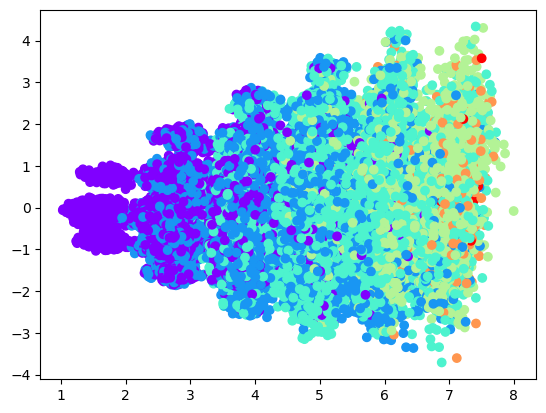

In [17]:
X_tsvd = TruncatedSVD(2).fit_transform(X.values)
plt.scatter(X_tsvd[:, 0], X_tsvd[:, 1], cmap='rainbow', c=y)

В анализе всего две компонентны, так что график не слишком информативный, но все равно дает представление о том, как фичи представляют выборку.

#### Самые важные фичи

In [18]:
df_feat = pd.DataFrame([X_train.columns, clf.feature_importances_]).T
df_feat[df_feat[1]!=0].sort_values(by=1, ascending=False).head(30).T

,195,117,116,107,119,102,121,120,111,114,...,103,110,27,135,142,105,126,136,25,9
0,distance,о,н,е,р,а,т,с,и,л,...,б,з,gender_femn,а_syl_1,е_syl_2,г,ч,а_syl_2,case_nomn,pos_NOUN
1,79089,16210,14718,14005,13256,12554,11889,11720,11133,10159,...,3020,3008,2930,2926,2909,2892,2615,2562,2436,2389


Итог: все признаки вносят свой вклад, при этом наиболее влиятельным является расстояние Левенштейна.

#### Неиспользованные фичи

In [19]:
df_feat[df_feat[1]==0].T

,5,10,12,13,14,21,23,26,49,69,95,98,101,150,151,152,191,192,193,194
0,pos_CONJ,pos_NPRO,pos_PRCL,pos_PRED,pos_PREP,case_gen2,case_loc2,case_voct,starts_with_й,starts_with_ё,ends_with_щ,ends_with_э,ends_with_ё,ё_syl_4,ё_syl_5,ё_syl_6,э_syl_3,э_syl_4,э_syl_5,э_syl_6
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### процент ошибок на каждом количестве слогов

In [20]:
df = df[df['id'].isin(X_test.sort_index().index)]
df['pred_stress'] = clf.predict(X_test.sort_index())
df[df['pred_stress']!=df['stress']]['num_syllables'].value_counts()/df['num_syllables'].value_counts()

1         NaN
2    0.179731
3    0.176485
4    0.139321
5    0.116745
6    0.098495
Name: num_syllables, dtype: float64

Больше всего ошибок на словах с 2, 3 и 4 слогами; эти слова наиболее часто встречаются как в выборке, так и в языке. 

## Обучение финального классификатора и предсказание для контрольной выборки

In [21]:
%%time

clf.fit(X, y)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
Wall time: 12.4 s


LGBMClassifier(boosting='gbdt', lambda_l2=1, num_leaves=2048)

In [22]:
df_public[feature_list+chars] = df_public.apply(lambda row : feature_engineering(row['word'], row['lemma']), axis = 1).tolist()
X_public = pd.concat([pd.get_dummies(df_public[(feature_final_list+['num_syllables'])]), df_public[chars], df_public[syl_list], df_public['distance']], axis=1).astype('float32')

In [23]:
%%time

df_public['stress'] = clf.predict(X_public)
df_public[['id', 'stress']].to_csv('output.csv', index=False)

Wall time: 295 ms
